In [51]:
#data
import yfinance as yf
import datetime
import numpy as np

def get_historical_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False,interval="1wk")
    return data['Close']

# Define the tickers for the S&P 500 index and the 20 stocks
tickers = ['^GSPC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'V', 'JNJ', 'UNH', 'BAC', 'TSLA', 'NVDA', 'WMT', 'PG', 'VZ', 'MA', 'HD', 'DIS', 'CMCSA']

# Calculate the start and end dates for the last six months
end = datetime.date.today() #out-of-sample
start = end  - datetime.timedelta(days=400) #out-of-sample

#out-of-sample prices
out_prices = get_historical_prices(tickers, start, end)

end_date = end  - datetime.timedelta(days=400) #in-sample
start_date = end_date - datetime.timedelta(days=1000) #in-sample

# Retrieve the historical prices for the tickers
prices = get_historical_prices(tickers, start_date, end_date)

# Print the retrieved prices
print(prices,prices.shape,prices.pct_change())


                  AAPL        AMZN        BAC      CMCSA         DIS   
Date                                                                   
2020-01-27   77.377502  100.435997  32.830002  43.189999  138.309998  \
2020-02-03   80.007500  103.963997  34.610001  44.740002  141.020004   
2020-02-10   81.237503  106.743500  34.849998  46.090000  139.539993   
2020-02-17   78.262497  104.798500  34.360001  45.820000  138.970001   
2020-02-24   68.339996   94.187500  28.500000  40.430000  117.650002   
...                ...         ...        ...        ...         ...   
2022-09-26  138.199997  113.000000  30.200001  29.330000   94.330002   
2022-10-03  140.089996  114.559998  30.750000  29.270000   97.160004   
2022-10-10  138.380005  106.900002  31.700001  30.049999   94.449997   
2022-10-17  147.270004  119.320000  34.950001  30.480000  102.040001   
2022-10-24  149.350006  115.660004  35.700001  31.500000  104.629997   

                 GOOGL          HD         JNJ         JPM     

In [52]:
import pyomo.environ as pyo

# create a model
model = pyo.ConcreteModel()


#model size parameters
T = prices.shape[0]
N = prices.shape[1]-1
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
model.N = pyo.Param(initialize = prices.shape[1]-1) #universe of assets #all dataset - index itself

#indices
model.i = pyo.Set(initialize = np.arange(model.N))#index for stocks
model.t = pyo.Set(initialize = np.arange(model.T))#index for time periods starts from 0
model.t0 = pyo.Set(initialize = np.arange(1,model.T))

#model parameters
V =  np.array(prices.drop(['^GSPC'] ,axis = 1)).T
model.V = pyo.Param(model.i,model.t,initialize = lambda m, i, t: V[i,t])
model.V0 = pyo.Param(model.i,model.t0,initialize = lambda m, i, t0: V[i,t0])

R = np.array([np.log(np.array(prices['^GSPC'][t])/np.array(prices['^GSPC'][t-1])) if t!=0 else np.log(np.array(prices['^GSPC'][1])/np.array(prices['^GSPC'][0]))  for t in model.t ]) #return of index in period t
model.R = pyo.Param(model.t,initialize = lambda m,t:R[t])

I = np.array(prices['^GSPC']) #value of index in period t
model.I = pyo.Param(model.t,initialize = lambda m,t:I[t])

model.epsilon = pyo.Param(model.i,initialize = 0.01)
model.delta = pyo.Param(model.i,initialize = 0.99)

model.K = pyo.Param(initialize = 10) #cardinality
model.gamma = pyo.Param(initialize = 0.5) #portfolio of C that can be consumed for transaction costs
model.trans = pyo.Param(initialize = 0.01) #amount of transaction if consumed to move from V[i,T]X[i] to V[i,T]x[i] or vice verca
model.C_cash = pyo.Param(initialize = 100000) #$
X = np.random.randint(1,size = (N,))
model.X = pyo.Param(model.i,initialize = lambda m,i:X[i]) #current tracking portfolio


print(f'we have {model.N+1-1} assets and {model.T+1} periods')
print(f'our random initial portfolio: {[model.X[i] for i in range(N)]}')

# declare decision variables
# model.X = pyo.Var(model.i,domain=pyo.PositiveIntegers,bounds = (0,200)) #unit of asset i in current tracking portfolio
model.x = pyo.Var(model.i,domain=pyo.NonNegativeReals,bounds = (0,1000)) #unit of asset i in new tracking portfolio
model.z = pyo.Var(model.i,domain = pyo.Binary ) #1 if asset selected

#auxilary parameters and variables
model.M = pyo.Param(initialize = 50000000)
model.p = pyo.Var(model.t0,domain = pyo.NonNegativeReals) #1 not penelizing positive deviation
model.n = pyo.Var(model.t0,domain = pyo.NonNegativeReals) #1 not penelizing positive deviation

devision_error = 1e-06
#parameters with expressions
# def r_expression_rule(model,t):
#   return (sum(model.V[i,t] * model.x[i] for i in model.i)/ (devision_error+sum(model.V[i,t-1] * model.x[i] for i in model.i)))-1
# def abs_expression_rule(model,t):
#   if ((sum(model.V[i,t] * model.x[i] for i in model.i)/ (devision_error+sum(model.V[i,t-1] * model.x[i] for i in model.i)))-1)>=model.R[t]:
#     return 0
#   else:
#     return abs(((sum(model.V[i,t] * model.x[i] for i in model.i)/ (devision_error+sum(model.V[i,t-1] * model.x[i] for i in model.i)))-1)-model.R[t])

# model.r = pyo.Expression(model.t0, rule=r_expression_rule)
# model.abs_expression_rule =pyo.Expression(model.t0,rule = abs_expression_rule )





#objective
def Obj(model):

  return 1/T * sum(model.p[t]   for t in model.t0 )
  
  # return 1/T * sum(model.p[t] + model.n[t]  for t in model.t0 ) #with the help of additional variables calculates downside returns (infeasible)
  
  
  # return 1/T * (sum(((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  # (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    ) - model.R[t]  for t in model.t0 )) #objewctive has to be maximization

  
  # return 1/T * sum( abs(model.R[t]-((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  #  (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1  ) )    for t in range(1,len(model.t)) ) #penalize both directions



  
  




#constraints
def Co1(model): #cardinality #3
  return sum(model.z[i] for i in model.i) == model.K 
def Co2(model,i): #cardinality
  return ((model.V[i,T-1] * model.x[i]) / (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash)  ) <= model.z[i] * model.delta[i] #4  
def Co3(model,i): #cardinality
  return ((model.V[i,T-1] * model.x[i]) / (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash)  ) >= model.z[i] * model.epsilon[i] #4
def Co4(model): #5 maximum amount that is allowed to use for transaction
  return sum(abs(model.x[i] - model.X[i])  * model.trans * model.V[i,T-1] for i in model.i) <= model.gamma * (sum(model.V[i,T-1]*model.X[i]  for i in model.i)+model.C_cash) #5
  # return sum(((model.x[i] - model.X[i])*model.xX[i]+(model.X[i] - model.x[i])*(1-model.xX[i]))  * model.trans * model.V[i,T-1] for i in model.i) <= model.gamma * (sum(model.V[i,T-1]*model.X[i]  for i in model.i)+model.C_cash) #5
def Co5(model): #6
  return sum(model.V[i,T-1] * model.x[i] for i in model.i) == (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash) - sum(abs(model.x[i] - model.X[i])  * model.trans * model.V[i,T-1] for i in model.i)

# def Co6(model,i):#to linearize abs in constraint 5 and 6
#   return (model.x[i] - model.X[i]) * model.xX[i] + (model.X[i] - model.x[i]) * (1-model.xX[i])  >= 0  
  
def Co7(model,t): #does not penalize objective for excess returns
  # return ( ((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  # (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    )- model.R[t] ) <=(model.M)*(1-model.y[t]) 
  return ( ((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    )- model.R[t] ) ==model.p[t]-model.n[t] 
# def Co8(model,t):
#   # return ( model.R[t]- ((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
#   # (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    ) )<=(model.M)*(model.y[t])
#   return ( ((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
#   (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    )- model.R[t] ) >=-model.p[t]+model.n[t] 
  
def Co9(model,t):
    return ( model.R[t] - ((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1    ) )  <=model.p[t]



# for t in model.t0:
#   print(f' r: {sum(model.V[i,t] * 1 for i in model.i)/ (sum(model.V[i,t-1] *1 for i in model.i)+devision_error)-1}  ,R: {model.R[t]} r-R: {(sum(model.V[i,t] * 1 for i in model.i)/ (sum(model.V[i,t-1] *1 for i in model.i)+devision_error)-1)-(model.R[t])}')

#constructing model
model.obj = pyo.Objective(rule = Obj,sense = pyo.minimize)
model.Co1 = pyo.Constraint(rule = Co1)
model.Co2 = pyo.Constraint(model.i,rule = Co2)
model.Co3 = pyo.Constraint(model.i,rule = Co3)
model.Co4 = pyo.Constraint(rule = Co4)
model.Co5 = pyo.Constraint(rule = Co5)
# model.Co6 = pyo.Constraint(model.i,rule = Co6) #softwere do it itself
# model.Co7 = pyo.Constraint(model.t0,rule = Co7) #p_t - n_t
# model.Co8 = pyo.Constraint(model.t0,rule = Co8) #will be deleted soon
model.Co9 = pyo.Constraint(model.t0,rule = Co9)
# model.Co10 = pyo.Constraint(model.t0,rule = Co10)




we have 18 assets and 145 periods
our random initial portfolio: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from pyomo.core.expr.visitor import identify_variables
from pyomo.core.base.var import IndexedVar

for constraint in model.component_data_objects(pyo.Constraint, active=True):
    print(f"{constraint}: {constraint.body}")

    variables = identify_variables(constraint.body)
    for var in variables:
        if isinstance(var, IndexedVar):
            var_name = f"{var.name}[{','.join(map(str, var.index_set()))}]"
        else:
            var_name = var.name
        print(f"\t{var_name}: {var.value}")

    print()
objective = model.component('obj')
print(f"Objective: {objective.expr}")

In [53]:
# import logging
# logging.getLogger('pyomo.core').setLevel(logging.DEBUG)
#solvers
# solver = pyo.SolverFactory('glpk',executable = 'C:\glpk-4.65\w64\glpsol')
#ALPHAECP
options = {'LIMTIME': 0.3}
solver = pyo.SolverFactory('gams')#, options=options)
# solver.options['optcr'] = 0.01  # Set the optimality criterion
# solver.options['reslim'] = 60  # Set the time limit in seconds
results = solver.solve(model,  solver='bonmin')#,tee=True) #ALPHAECP,keepfiles=True,
                            # 

# pyo.SolverFactory('mindtpy').solve(model,
#                                    strategy='GOA',
#                                    mip_solver='cplex',
#                                    nlp_solver='scip')
model.display()
# model.pprint()

Model unknown

  Variables:
    x : Size=18, Index=i
        Key : Lower : Value             : Upper : Fixed : Stale : Domain
          0 :     0 :   70.684900781418 :  1000 : False : False : NonNegativeReals
          1 :     0 : 51.07656572345283 :  1000 : False : False : NonNegativeReals
          2 :     0 : 394.1160042735321 :  1000 : False : False : NonNegativeReals
          3 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          4 :     0 : 39.56715072614176 :  1000 : False : False : NonNegativeReals
          5 :     0 : 94.94026413696344 :  1000 : False : False : NonNegativeReals
          6 :     0 :  27.0159877466752 :  1000 : False : False : NonNegativeReals
          7 :     0 : 75.45968759857314 :  1000 : False : False : NonNegativeReals
          8 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          9 :     0 : 17.81717038691847 :  1000 : False : False : NonNegativeReals
         10 :     0 :               0.0 :  1

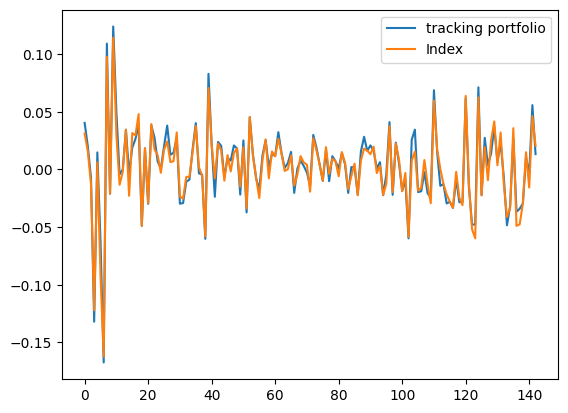

In [54]:
#plotting model.x portfolio from t=1,...,T
import matplotlib.pyplot as plt
r_tracking = [(sum(model.V[i,t]*model.x[i].value for i in model.i))/(sum(model.V[i,t-1]*model.x[i].value for i in model.i))-1  for t in model.t0 ]
Index = [model.R[t] for t in model.t0]
plt.plot(r_tracking,label = 'tracking portfolio')
plt.plot(Index , label = 'Index')
plt.legend()
plt.show()


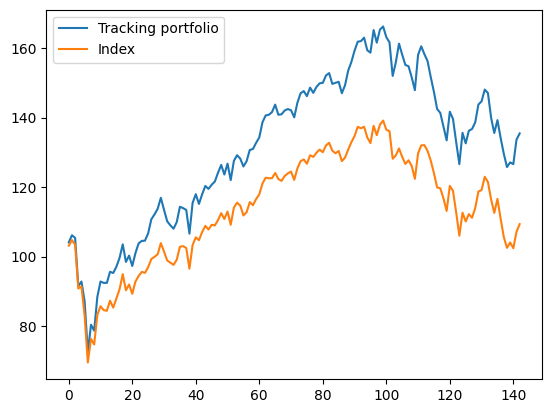

In [55]:
tracking = []
index = []
tracking.append( 100*(1+r_tracking[0]))
index.append(100*(1+Index[0]))
for i in range(1,len(Index)):
    tracking.append(tracking[i-1]*(1+r_tracking[i]))
    index.append(index[i-1]*(1+Index[i]))
plt.plot(tracking,label = 'Tracking portfolio')
plt.plot(index,label = 'Index')
plt.legend()
plt.show()

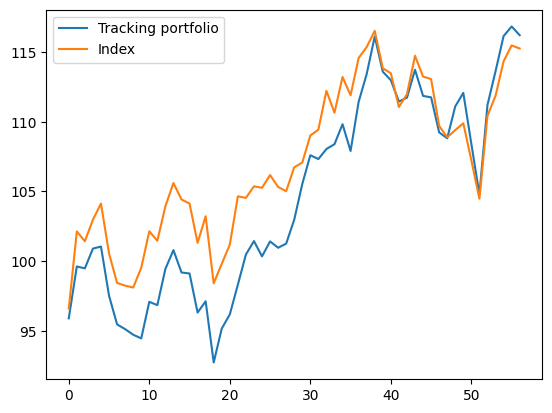

In [56]:
#out-of-sample performance

V_out =  np.array(out_prices.drop(['^GSPC'] ,axis = 1)).T
R_out = np.array([np.log(np.array(out_prices['^GSPC'][t])/np.array(out_prices['^GSPC'][t-1])) 
if t!=0 else np.log(np.array(out_prices['^GSPC'][1])/np.array(out_prices['^GSPC'][0]))  for t in range(V_out.shape[1]) ]) #return of index in period t
r_tracking = [(sum(V_out[i,t]*model.x[i].value for i in model.i))/(sum(V_out[i,t-1]*model.x[i].value for i in model.i))-1  for t in range(1,V_out.shape[1]) ]
Index = [R_out[t] for t in range(1,V_out.shape[1])]
tracking = []
index = []
tracking.append( 100*(1+r_tracking[0]))
index.append(100*(1+Index[0]))
for i in range(1,len(Index)):
    tracking.append(tracking[i-1]*(1+r_tracking[i]))
    index.append(index[i-1]*(1+Index[i]))
plt.plot(tracking,label = 'Tracking portfolio')
plt.plot(index,label = 'Index')
plt.legend()
plt.show()




portfolio return: 0.2836635635256246 
 index return: 0.14858505387269383


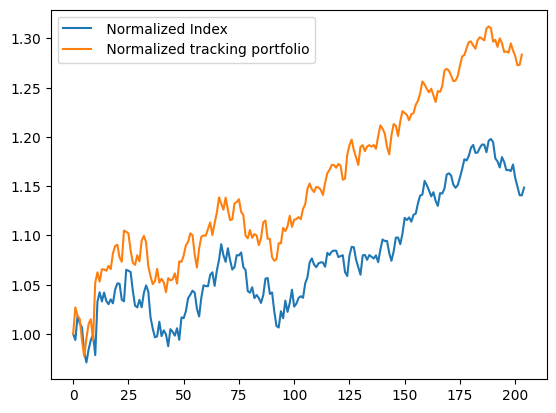

In [6]:
I = I/I[0]
y = [100 * (1 + sum(r_tracking[:i])) for i in range(1, len(r_tracking)+1)]
print(f'portfolio return: {(y[-1]/y[0])-1} \n index return: {(I[-1]/I[0])-1}')
y = y/y[0]
plt.plot(I,label=' Normalized Index')
plt.plot(y,label=' Normalized tracking portfolio')
plt.legend()
plt.show()
